# Quantitative analysis of the binaries in the RGB

In [22]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.widgets import PolygonSelector, Button
from matplotlib.path import Path
import csv

%matplotlib widget

/var/folders/nx/ljvhqy816sn3y2d3hzwxcqhc0000gn/T/ipykernel_26362/3127786437.py:3: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('TkAgg')


In [23]:
import sys
import os

# set the path to the tools folder
module_path = '/Users/giadaaggio/Desktop/Thesis/TOTORO/CODES/tools'
sys.path.append(module_path)

from binaries_utils import BinaryStarUtils
binary = BinaryStarUtils()

In [24]:
colormap = plt.cm.jet

In [25]:
# load and clean data
input_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc0104_multi_v1_catalog-meth1.txt'
df = pd.read_csv(input_file, header=None, delim_whitespace=True, 
                   usecols=[0, 1, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32], 
                   names=['X','Y','F275W','rad_275','F336W','rad_336','F435W','rad_435','F606W','rad_606','F814W','rad_814','prob_member'], skiprows=55)

df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

In [26]:
# flag the data that are ok (membership probability and radxs)
# set the conditions
conditions = (
    (df['prob_member'] >= 90) & 
    (np.abs(df['rad_275']) < 0.05) &
    (np.abs(df['rad_336']) < 0.05) &
    (np.abs(df['rad_435']) < 0.05) &
    (np.abs(df['rad_606']) < 0.05) &
    (np.abs(df['rad_814']) < 0.05) 
    )   

# assign the flag 
df['flag'] = np.where(conditions, 1, 0)

In [27]:
# select the data with flag 1 
data = df[df['flag'] == 1]

<div class = 'alert alert-block alert-info'>
In the next cell you can exclude the center of the cluster to be more consistent with the paper
</div>

In [43]:
exclude_center = False

if exclude_center == True: 
    data_all = data.copy()

    # convert in pixels the minimum radius in arcmin
    R_min = 0.83                        # arcmin
    image_scale = 0.0395                # arcsec/pixel 
    R_min = R_min * 60 / image_scale    # pixels

    # identify the center of the cluster
    X_center, Y_center = 5000, 5000

    # exclude the center of the cluster (data that are inside R_min)
    data = data[(data['X']-X_center)**2 + (data['Y']-Y_center)**2 > R_min**2]

    # print the spatial distribution of the data
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(data_all['X'], data_all['Y'], s=0.1, c='grey')
    ax.scatter(data['X'], data['Y'], s=0.1, c='black')
    plt.show()

In [44]:
primary_stars = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/primary_stars.csv', delim_whitespace=True)
primary_stars['index'] = primary_stars.index
color_test = colors = binary.color_index(primary_stars, 'index', colormap)

BS_RGB_vis = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_RGB_vis.csv', delim_whitespace=True)
BS_RGB_uv = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_RGB_uv.csv', delim_whitespace=True)

color_vis = binary.color_index(BS_RGB_vis, 'secondary', colormap)
color_uv = binary.color_index(BS_RGB_uv, 'secondary', colormap)

In [45]:
primary_vis_high = BS_RGB_vis[BS_RGB_vis['primary'] == 9]
primary_vis_low = BS_RGB_vis[BS_RGB_vis['primary'] == 13]

bound_bin_vis_high = primary_vis_high[primary_vis_high['secondary'] == 4]
bound_bin_vis_low = primary_vis_low[primary_vis_low['secondary'] == 4]

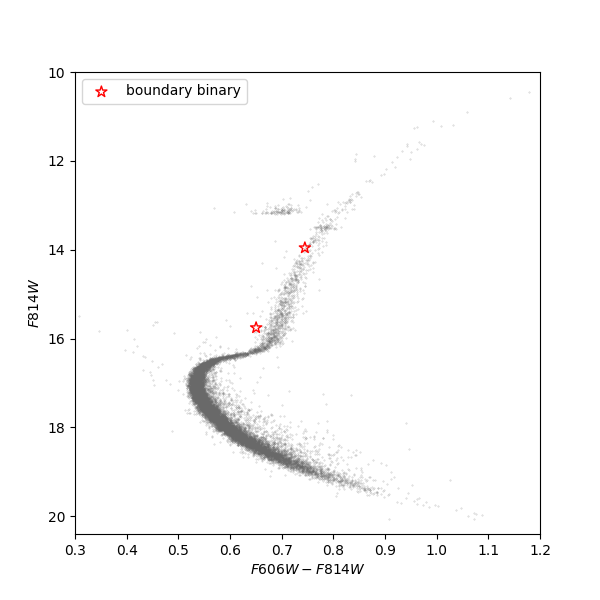

In [59]:
plt.figure(figsize=(6, 6))

# plot optical filters

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(bound_bin_vis_high['F606W']-bound_bin_vis_high['F814W'], bound_bin_vis_high['F814W'], s=70, edgecolor='red', facecolors='none', label='boundary binary', marker='*', zorder=5)
plt.scatter(bound_bin_vis_low['F606W']-bound_bin_vis_low['F814W'], bound_bin_vis_low['F814W'], s=70, edgecolor='red', facecolors='none', marker='*', zorder=5)
plt.gca().invert_yaxis()

plt.xlim(0.3,1.2)
plt.ylim(20.4,10)
plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='upper left')

plt.show()

### Optical CMD

<div class= 'alert alert-block alert-info'>
Use <b><tt>region_selection = True</b></tt> if you need to re-select the regions for computing the binary fraction, otherwise leave it to <b><tt>False</b></tt>
</div>

In [47]:
# Do you need to select the stars?
region_selection = False

In [48]:
from CMDAnalyzer import CMDRegionSelector

In [49]:
if region_selection is True:
    cmd_select_vis = CMDRegionSelector(
        data = data,
        color = data['F606W'] - data['F814W'],
        magnitude = data['F814W'],
        color_bound_bin_high = bound_bin_vis_high['F606W'] - bound_bin_vis_high['F814W'],
        magnitude_bound_bin_high = bound_bin_vis_high['F814W'],
        color_bound_bin_low = bound_bin_vis_low['F606W'] - bound_bin_vis_low['F814W'],
        magnitude_bound_bin_low = bound_bin_vis_low['F814W'],
        x_label='F606W-F814W',
        y_label='F814W',
        output_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F606W_F814W.csv'
    )

In [50]:
region_vis = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F606W_F814W.csv')

region_vis_A = CMDRegionSelector.get_stars_inside_region(
    region_id = 0,
    data = data, 
    color = data['F606W']-data['F814W'], 
    magnitude = data['F814W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F606W_F814W.csv')

region_vis_B = CMDRegionSelector.get_stars_inside_region(
    region_id = 1,
    data = data, 
    color = data['F606W']-data['F814W'], 
    magnitude = data['F814W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F606W_F814W.csv')

# compute the error on the binary fraction
error_vis_A = np.sqrt(len(region_vis_A) - 1)
error_vis_B = np.sqrt(len(region_vis_B) - 1)

print('Region A: ', len(region_vis_A), '+/-', error_vis_A)
print('Region B: ', len(region_vis_B), '+/-', error_vis_B)

frac_RGB_bin_vis = len(region_vis_B) / (len(region_vis_A) + len(region_vis_B))
err_RGB_bin_vis = (np.sqrt(len(region_vis_B)**2 * error_vis_A**2 + len(region_vis_A)**2 * error_vis_B**2)) / ((len(region_vis_A) + len(region_vis_B))**2)

print('Binary fraction: ', frac_RGB_bin_vis, '+/-', err_RGB_bin_vis)

Region A:  806 +/- 28.372521918222215
Region B:  14 +/- 3.605551275463989
Binary fraction:  0.01707317073170732 +/- 0.0043621286338070085


In [51]:
region_names = {
    0: 'Region A',
    1: 'Region B',
}

region_colors = {
    0: 'red',
    1: 'blue',
}

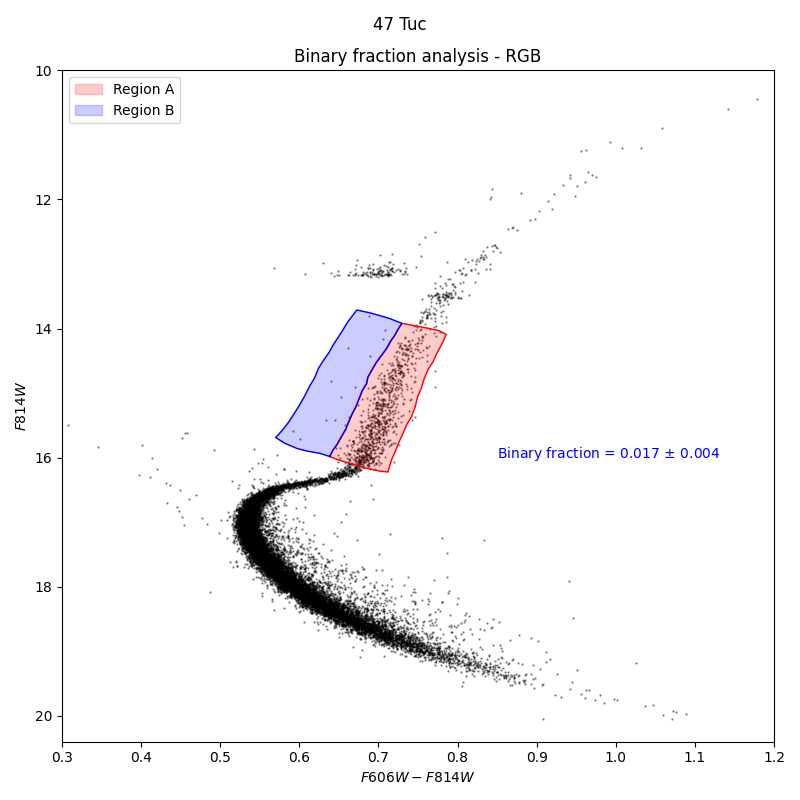

In [52]:
# Plot the CMD
fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(data['F606W'] - data['F814W'], data['F814W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax.invert_yaxis()
ax.set_xlim(0.3, 1.2)
ax.set_ylim(20.4, 10)
ax.set_xlabel(r'$F606W-F814W$')
ax.set_ylabel(r'$F814W$')

# Group by Region_ID and plot each region
for region_id, region in region_vis.groupby("Region_ID"):
    # Append the first point to close the polygon
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")  # Default to "Region X"

    # Fill the inside of the region
    ax.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)

    # Plot the region outline
    ax.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

# Add text to the plot using the value of the variable
ax.text(0.85, 16, f'Binary fraction = {frac_RGB_bin_vis:.3f} $\pm$ {err_RGB_bin_vis:.3f}', fontsize=10, color='blue')
ax.set_title('Binary fraction analysis - RGB')

plt.suptitle('47 Tuc', fontsize=12)

ax.legend()
plt.tight_layout()
plt.show()

### UV CMD

<div class='alert alert-block alert-warning'>
We can't do the same analysis in the UV due to the <b>presence of multipopulation</b> that concurr to the broadening of the sequences. 
</div>

## Isochrones fitting

<div class = 'alert alert-block alert-info'>
In this case we use the alpha-enhanced isochrone. 
</div>

In [53]:
iso_basti_1 = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/FEHm075/12000z0054990y255P04O1D1E1.isc_acs', delim_whitespace=True, skiprows=6)

# distance modulus and color excess E(B-V)
distance_modulus = 13.21
color_excess = 0.02

# coefficients for the reddening correction 
R_I = 1.8420        # F814W
R_V = 2.8782        # F606W

iso_basti_1['F606W'] = iso_basti_1['F606W'] + distance_modulus + color_excess * R_V
iso_basti_1['F814W'] = iso_basti_1['F814W'] + distance_modulus + color_excess * R_I

In [54]:
prim_for_ratio = primary_stars[primary_stars['index'] == 9]
sec_for_ratio = primary_stars[primary_stars['index'] == 4]

In [55]:
magnitude_prim = prim_for_ratio['F814W'].values[0]
magnitude_sec = sec_for_ratio['F814W'].values[0]

In [56]:
# find the point in iso_basti_1 that is closest to the magnitude of the primary star
idx_prim = (iso_basti_1['F814W']-magnitude_prim).abs().idxmin()
mass_prim = iso_basti_1['M/Mo(ini)'].iloc[idx_prim]
print('mass of the primary:', mass_prim)

idx_sec_low = (iso_basti_1['F814W']-magnitude_sec).abs().idxmin()
mass_sec_low = iso_basti_1['M/Mo(ini)'].iloc[idx_sec_low]
print('mass of the secondary for lower limit:', mass_sec_low)


# compute the mass ratio of the two stars
q_low = mass_sec_low/mass_prim
print('lowest q we can detect:', q_low)

mass of the primary: 0.8857568865
mass of the secondary for lower limit: 0.8028785033
lowest q we can detect: 0.9064321322665777


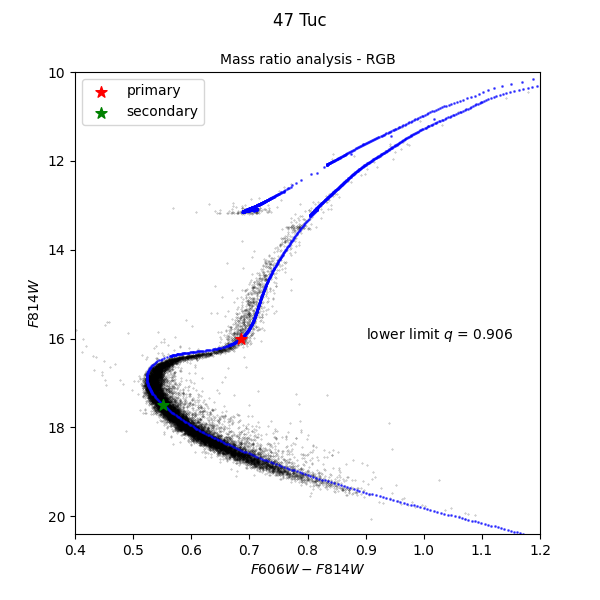

In [57]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.scatter(iso_basti_1['F606W']-iso_basti_1['F814W'], iso_basti_1['F814W'], s=1, c='blue', alpha=0.6, zorder=2)
plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='black', alpha=0.4, zorder=1)
plt.scatter(iso_basti_1['F606W'].iloc[idx_prim]-iso_basti_1['F814W'].iloc[idx_prim], iso_basti_1['F814W'].iloc[idx_prim], s=70, color='red', label='primary', marker='*', zorder=3)
plt.scatter(iso_basti_1['F606W'].iloc[idx_sec_low]-iso_basti_1['F814W'].iloc[idx_sec_low], iso_basti_1['F814W'].iloc[idx_sec_low], s=70, color='green', label='secondary', marker='*', zorder=3)

plt.gca().invert_yaxis()

plt.xlim(0.4,1.2)
plt.ylim(20.4,10)
plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='upper left')
plt.title('Mass ratio analysis - RGB', fontsize=10)
plt.suptitle('47 Tuc', fontsize=12)

ax.text(0.9, 16, f'lower limit $q$ = {q_low:.3f}', fontsize=10, color='black')

plt.show()

